In [33]:
#### MICHIGAN STATE EXPLORE DATA SCRATCHBOOK 

## 1. Import Libraries
# Dependencies
import pandas as pd
import sqlite3

## Datafile - Current Season





path = '../workbook/db_files_raw/2021 Game Stats.db'

db_path = path # for use by the MSU Specific SQL queries
TAG = "2022 Season"

# Load the database
conn = sqlite3.connect(path)


# Get the list of tables in the database
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
table_names = [table[0] for table in tables]

# table_names

# Penelties

## First Create a dictionary of the classes of penelty


### Penelty Classification

- Physical Aggressiveness: Boarding, Charging, Elbowing, Roughing
- Stick Infractions: Slashing, High-Sticking, Hooking, Holding the Stick
- Game Flow Disruptions: Delay of Game, Unsportsmanlike Conduct, Interference
- Illegal Contact: Kneeing, Tripping
- Contact to the Head: Contact to the Head

We'll use these subcategories along with the broader categories like Minor, Major, Misconduct, and Match Penalties to create a multi-level classification.


In [34]:
# Creating a Python dictionary to map each penalty type to its corresponding category and subcategory

# Subcategories for Minor Penalties
minor_subcategories = {
    'Physical Aggressiveness': ['Boarding', 'Charging', 'Elbowing', 'Roughing'],
    'Stick Infractions': ['Slashing', 'High-Sticking', 'Hooking', 'Holding the Stick'],
    'Game Flow Disruptions': ['Delay of Game', 'Unsportsmanlike Conduct', 'Interference'],
    'Illegal Contact': ['Kneeing', 'Tripping'],
    'Contact to the Head': ['Contact to the Head']
}

# Other broader categories (for illustration, actual list should be based on the data)
major_penalties = ['Butt-Ending', 'Checking from Behind', 'Fighting', 'Fight Instigator', 'Holding/Grasping the Facemask', 'Pushing-off of Opponent with Skate', 'Leaving the Bench During an Altercation', 'Spearing']
misconduct_penalties = ['Misconduct']  # Placeholder, actual list should be based on the data
match_penalties = ['Match Penalty']  # Placeholder, actual list should be based on the data

# Initialize the mapping dictionary
penalty_mapping = {}

# Fill in the dictionary for minor penalties
for subcategory, penalties in minor_subcategories.items():
    for penalty in penalties:
        penalty_mapping[penalty] = {'Category': 'Minor', 'Subcategory': subcategory}

# Fill in the dictionary for major, misconduct, and match penalties (without subcategories)
for penalty in major_penalties:
    penalty_mapping[penalty] = {'Category': 'Major', 'Subcategory': None}
for penalty in misconduct_penalties:
    penalty_mapping[penalty] = {'Category': 'Misconduct', 'Subcategory': None}
for penalty in match_penalties:
    penalty_mapping[penalty] = {'Category': 'Match', 'Subcategory': None}

# Show the penalty mapping dictionary
# penalty_mapping



## By Referee Across entire dataset


In [35]:
# Fetching data from the game_details and penalty_summary tables
query_game_details_data = "SELECT * FROM game_details;"
query_penalty_summary_data = "SELECT * FROM penalty_summary;"

# Execute the queries and fetch results into DataFrames
df_game_details = pd.read_sql(query_game_details_data, conn)
df_penalty_summary = pd.read_sql(query_penalty_summary_data, conn)

# Merge the DataFrames on Game_ID to get referee information along with penalties
df_merged = pd.merge(df_penalty_summary, df_game_details, on='Game_ID')

# Add the penalty classifications (assuming the mapping dictionary 'penalty_mapping' is already defined)
df_merged['Category'] = df_merged['Penalty_Type'].map(lambda x: penalty_mapping.get(x, {}).get('Category', 'Unknown'))
df_merged['Subcategory'] = df_merged['Penalty_Type'].map(lambda x: penalty_mapping.get(x, {}).get('Subcategory', 'Unknown'))


# Show the first few rows of the merged DataFrame to verify
# df_merged.head()

# Count the number of games each referee has worked
game_count_ref1 = df_merged.groupby('Ref1')['Game_ID'].nunique().reset_index().rename(columns={'Ref1': 'Referee', 'Game_ID': 'GameCount'})
game_count_ref2 = df_merged.groupby('Ref2')['Game_ID'].nunique().reset_index().rename(columns={'Ref2': 'Referee', 'Game_ID': 'GameCount'})
game_count = pd.concat([game_count_ref1, game_count_ref2]).groupby('Referee').sum().reset_index()

# Calculate the total number of penalty minutes each referee has called
penalty_minutes_ref1 = df_merged.groupby('Ref1')['Pen_Length'].apply(lambda x: x.astype(int).sum()).reset_index().rename(columns={'Ref1': 'Referee', 'Pen_Length': 'TotalPenaltyMinutes'})
penalty_minutes_ref2 = df_merged.groupby('Ref2')['Pen_Length'].apply(lambda x: x.astype(int).sum()).reset_index().rename(columns={'Ref2': 'Referee', 'Pen_Length': 'TotalPenaltyMinutes'})
penalty_minutes = pd.concat([penalty_minutes_ref1, penalty_minutes_ref2]).groupby('Referee').sum().reset_index()

# Calculate the total count of penalties each referee has called
penalty_count_ref1 = df_merged.groupby('Ref1').size().reset_index().rename(columns={0: 'TotalPenaltyCount', 'Ref1': 'Referee'})
penalty_count_ref2 = df_merged.groupby('Ref2').size().reset_index().rename(columns={0: 'TotalPenaltyCount', 'Ref2': 'Referee'})
penalty_count = pd.concat([penalty_count_ref1, penalty_count_ref2]).groupby('Referee').sum().reset_index()

# Merge all the aggregated DataFrames
df_ref_stats_python = pd.merge(game_count, penalty_minutes, on='Referee', how='outer')
df_ref_stats_python = pd.merge(df_ref_stats_python, penalty_count, on='Referee', how='outer')

# Calculate the average number of penalties and penalty minutes per game for each referee
df_ref_stats_python['AvgPenaltyMinutesPerGame'] = df_ref_stats_python['TotalPenaltyMinutes'] / df_ref_stats_python['GameCount']
df_ref_stats_python['AvgPenaltyCountPerGame'] = df_ref_stats_python['TotalPenaltyCount'] / df_ref_stats_python['GameCount']

# Sort by average penalty count per game
df_ref_stats_python = df_ref_stats_python.sort_values(by='AvgPenaltyCountPerGame', ascending=False).reset_index(drop=True)


# Identifying the unique types of penalties in the data
unique_penalty_types = df_merged['Penalty_Type'].unique()

# Initialize an empty DataFrame to hold the aggregated data
df_penalty_type_breakdown = pd.DataFrame()

# Loop through each unique penalty type to calculate the total minutes for each referee
for penalty_type in unique_penalty_types:
    penalty_minutes_ref1 = df_merged[df_merged['Penalty_Type'] == penalty_type].groupby('Ref1')['Pen_Length'].apply(lambda x: x.astype(int).sum()).reset_index().rename(columns={'Ref1': 'Referee', 'Pen_Length': f"{penalty_type}_Minutes"})
    penalty_minutes_ref2 = df_merged[df_merged['Penalty_Type'] == penalty_type].groupby('Ref2')['Pen_Length'].apply(lambda x: x.astype(int).sum()).reset_index().rename(columns={'Ref2': 'Referee', 'Pen_Length': f"{penalty_type}_Minutes"})
    penalty_minutes = pd.concat([penalty_minutes_ref1, penalty_minutes_ref2]).groupby('Referee').sum().reset_index()
    
    # Merge with the existing DataFrame
    if df_penalty_type_breakdown.empty:
        df_penalty_type_breakdown = penalty_minutes
    else:
        df_penalty_type_breakdown = pd.merge(df_penalty_type_breakdown, penalty_minutes, on='Referee', how='outer')


##############################################
## Filter out referees with less than 10 games
# df_ref_stats_python = df_ref_stats_python[df_ref_stats_python['GameCount'] >= 10].reset_index(drop=True)
##################################################


# Merge the penalty type breakdown with the main referee stats DataFrame
df_ref_stats_extended = pd.merge(df_ref_stats_python, df_penalty_type_breakdown, on='Referee', how='outer')


# Sort by Game Count
df_ref_stats_extended = df_ref_stats_extended.sort_values(by='GameCount', ascending=False).reset_index(drop=True)


# Show the top of the DataFrame
df_ref_stats_extended.sample(10)


,Referee,GameCount,TotalPenaltyMinutes,TotalPenaltyCount,AvgPenaltyMinutesPerGame,AvgPenaltyCountPerGame,Kneeing_Minutes,Tripping_Minutes,Boarding_Minutes,Elbowing_Minutes,...,Fighting_Minutes,Facemasking_Minutes,Shot After the Whistle_Minutes,Duration:2_Minutes,Duration:5_Minutes,Closing Hand On Puck_Minutes,Disqualification_Minutes,Benchgamemisconduct_Minutes,Unsportsmanlike Conduct - Diving_Minutes,Kicking_Minutes
48,Brady Johnson,9,150,64,16.666667,7.111111,5.0,8.0,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,AJ Potvin,3,109,37,36.333333,12.333333,NaN,10.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,Andy OBrien,6,129,56,21.500000,9.333333,7.0,10.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,Kenny Anderson,8,107,48,13.375000,6.000000,2.0,16.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,Andrew Spinali,2,26,13,13.000000,6.500000,NaN,NaN,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,Tom DellaFranco,1,48,13,48.000000,13.000000,NaN,4.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183,Walter Holten,1,24,12,24.000000,12.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,Derek Berkebile,13,245,113,18.846154,8.692308,7.0,30.0,12.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,William McGoldrick III,3,73,31,24.333333,10.333333,NaN,2.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,Andy Bethmann,4,108,47,27.000000,11.750000,NaN,10.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# Function to aggregate referee stats based on new penalty classifications
def aggregate_referee_stats(df):
    # Initialize an empty DataFrame to store the final aggregated stats
    df_aggregated = pd.DataFrame()

    # List to store the types of aggregations (categories and subcategories)
    aggregation_types = df['Category'].unique().tolist() + df['Subcategory'].unique().tolist()
    aggregation_types = [x for x in aggregation_types if x != 'Unknown']

    # Loop through each aggregation type to perform the calculations
    for agg_type in aggregation_types:
        # Filtering data based on the aggregation type
        df_filtered = df[(df['Category'] == agg_type) | (df['Subcategory'] == agg_type)]

        # Calculating the aggregated stats for referees in Ref1 and Ref2 positions
        ref1_stats = df_filtered.groupby('Ref1')['Pen_Length'].apply(lambda x: x.astype(int).sum()).reset_index().rename(columns={'Ref1': 'Referee', 'Pen_Length': f"{agg_type}_Minutes"})
        ref2_stats = df_filtered.groupby('Ref2')['Pen_Length'].apply(lambda x: x.astype(int).sum()).reset_index().rename(columns={'Ref2': 'Referee', 'Pen_Length': f"{agg_type}_Minutes"})
        
        # Concatenating and summing up the stats for each referee
        aggregated_stats = pd.concat([ref1_stats, ref2_stats]).groupby('Referee').sum().reset_index()
        
        # Merging with the existing DataFrame
        if df_aggregated.empty:
            df_aggregated = aggregated_stats
        else:
            df_aggregated = pd.merge(df_aggregated, aggregated_stats, on='Referee', how='outer')
    
    return df_aggregated

# Using the function to aggregate the referee stats based on the new penalty classifications
df_ref_stats_updated = aggregate_referee_stats(df_merged)

# Merging with the main referee stats DataFrame
df_ref_stats_updated = pd.merge(df_ref_stats_python, df_ref_stats_updated, on='Referee', how='outer')

# drop the unnessecary original penalty columns

##############################################
## Filter out referees with less than 10 games
df_ref_stats_updated = df_ref_stats_updated[df_ref_stats_updated['GameCount'] >= 20].reset_index(drop=True)
##################################################


# Show the top of the DataFrame
df_ref_stats_updated.head()


,Referee,GameCount,TotalPenaltyMinutes,TotalPenaltyCount,AvgPenaltyMinutesPerGame,AvgPenaltyCountPerGame,Minor_Minutes,Misconduct_Minutes,Major_Minutes,Illegal Contact_Minutes,Physical Aggressiveness_Minutes,Stick Infractions_Minutes,Game Flow Disruptions_Minutes,Contact to the Head_Minutes,None_Minutes
0,Cameron Lynch,23,547,219,23.782609,9.521739,294,50.0,NaN,50.0,70.0,110.0,52.0,12.0,NaN
1,,510,11267,4410,22.092157,8.647059,6288,670.0,30.0,1384.0,1788.0,1666.0,1138.0,312.0,NaN
2,CJ Hanafin,20,340,159,17.000000,7.950000,224,NaN,NaN,44.0,46.0,100.0,34.0,NaN,NaN
3,Ryan Sweeney,21,406,159,19.333333,7.571429,228,NaN,NaN,52.0,54.0,68.0,44.0,10.0,NaN
4,Colin Kronforst,20,356,145,17.800000,7.250000,197,NaN,NaN,40.0,56.0,54.0,30.0,17.0,NaN


## Team by Team summary 

In [37]:


# Count the number of games each team has played
game_count_team = df_merged.groupby('Team')['Game_ID'].nunique().reset_index().rename(columns={'Game_ID': 'GameCount'})

# Calculate the total number of penalty minutes for each team
total_penalty_minutes_team = df_merged.groupby('Team')['Pen_Length'].apply(lambda x: x.astype(int).sum()).reset_index().rename(columns={'Pen_Length': 'TotalPenaltyMinutes'})

# Calculate the total count of penalties for each team
total_penalty_count_team = df_merged.groupby('Team').size().reset_index().rename(columns={0: 'TotalPenaltyCount'})

# Count the number of different players from each team who have been penalized
unique_players_penalized_team = df_merged.groupby('Team')['Player'].nunique().reset_index().rename(columns={'Player': 'UniquePlayersPenalized'})

# Initialize an empty DataFrame to hold the penalty type breakdown
df_team_penalty_type_breakdown = pd.DataFrame()

# Loop through each unique penalty type to calculate the total minutes for each team
for penalty_type in unique_penalty_types:
    team_penalty_minutes = df_merged[df_merged['Penalty_Type'] == penalty_type].groupby('Team')['Pen_Length'].apply(lambda x: x.astype(int).sum()).reset_index().rename(columns={'Pen_Length': f"{penalty_type}_Minutes"})
    
    # Merge with the existing DataFrame
    if df_team_penalty_type_breakdown.empty:
        df_team_penalty_type_breakdown = team_penalty_minutes
    else:
        df_team_penalty_type_breakdown = pd.merge(df_team_penalty_type_breakdown, team_penalty_minutes, on='Team', how='outer')

# Merge all the aggregated DataFrames to create the final team stats DataFrame
df_team_stats = pd.merge(game_count_team, total_penalty_minutes_team, on='Team', how='outer')
df_team_stats = pd.merge(df_team_stats, total_penalty_count_team, on='Team', how='outer')
df_team_stats = pd.merge(df_team_stats, unique_players_penalized_team, on='Team', how='outer')
df_team_stats = pd.merge(df_team_stats, df_team_penalty_type_breakdown, on='Team', how='outer')

# Calculate the average number of penalties and penalty minutes per game for each team
df_team_stats['AvgPenaltyMinutesPerGame'] = df_team_stats['TotalPenaltyMinutes'] / df_team_stats['GameCount']
df_team_stats['AvgPenaltyCountPerGame'] = df_team_stats['TotalPenaltyCount'] / df_team_stats['GameCount']

# Show the top of the DataFrame
# df_team_stats.head()


In [38]:
# Function to aggregate team stats based on new penalty classifications
def aggregate_team_stats(df):
    # Initialize an empty DataFrame to store the final aggregated stats
    df_aggregated = pd.DataFrame()

    # List to store the types of aggregations (categories and subcategories)
    aggregation_types = df['Category'].unique().tolist() + df['Subcategory'].unique().tolist()
    aggregation_types = [x for x in aggregation_types if x != 'Unknown']

    # Loop through each aggregation type to perform the calculations
    for agg_type in aggregation_types:
        # Filtering data based on the aggregation type
        df_filtered = df[(df['Category'] == agg_type) | (df['Subcategory'] == agg_type)]

        # Calculating the aggregated stats for each team
        team_stats = df_filtered.groupby('Team')['Pen_Length'].apply(lambda x: x.astype(int).sum()).reset_index().rename(columns={'Pen_Length': f"{agg_type}_Minutes"})
        
        # Merging with the existing DataFrame
        if df_aggregated.empty:
            df_aggregated = team_stats
        else:
            df_aggregated = pd.merge(df_aggregated, team_stats, on='Team', how='outer')
    
    return df_aggregated

# Using the function to aggregate the team stats based on the new penalty classifications
df_team_stats_updated = aggregate_team_stats(df_merged)

# Merge all the aggregated DataFrames to create the final team stats DataFrame
df_team_stats_final = pd.merge(game_count_team, total_penalty_minutes_team, on='Team', how='outer')
df_team_stats_final = pd.merge(df_team_stats_final, total_penalty_count_team, on='Team', how='outer')
df_team_stats_final = pd.merge(df_team_stats_final, unique_players_penalized_team, on='Team', how='outer')
df_team_stats_final = pd.merge(df_team_stats_final, df_team_stats_updated, on='Team', how='outer')

# Calculate the average number of penalties and penalty minutes per game for each team
df_team_stats_final['AvgPenaltyMinutesPerGame'] = df_team_stats_final['TotalPenaltyMinutes'] / df_team_stats_final['GameCount']
df_team_stats_final['AvgPenaltyCountPerGame'] = df_team_stats_final['TotalPenaltyCount'] / df_team_stats_final['GameCount']

# Dropping the old columns that are redundant with the new aggregation
# Since we've named the new columns differently, no old columns should be redundant in this case

# Show the top of the DataFrame
df_team_stats_final.head()




,Team,GameCount,TotalPenaltyMinutes,TotalPenaltyCount,UniquePlayersPenalized,Minor_Minutes,Misconduct_Minutes,Major_Minutes,Illegal Contact_Minutes,Physical Aggressiveness_Minutes,Stick Infractions_Minutes,Game Flow Disruptions_Minutes,Contact to the Head_Minutes,None_Minutes,AvgPenaltyMinutesPerGame,AvgPenaltyCountPerGame
0,AIC,36,335,143,24,208,20.0,NaN,40,54,80,24,10.0,NaN,9.305556,3.972222
1,ASU,35,527,185,23,268,100.0,5.0,52,96,66,39,15.0,NaN,15.057143,5.285714
2,Air Force,33,470,165,22,232,10.0,5.0,53,42,66,51,20.0,NaN,14.242424,5.000000
3,Alaska,34,534,197,28,286,30.0,20.0,44,70,88,65,19.0,NaN,15.705882,5.794118
4,Army,31,307,118,23,156,20.0,NaN,20,54,40,32,10.0,NaN,9.903226,3.806452


In [39]:

# Save the final DataFrames to CSV files with the TAG string
folder = '../data/tableau'

df_team_stats_final.to_csv(f'{folder}/penelties_by_team_{TAG}.csv', index=False)
df_ref_stats_updated.to_csv(f'{folder}/penelties_ref_stats_{TAG}.csv', index=False)



In [40]:
# SQL query to find the average count of penalties per referee per game
query_avg_count_penalty_per_ref = """
SELECT Referee, COUNT(*) / COUNT(DISTINCT Game_ID) AS Avg_Penalty_Count
FROM (
    SELECT Ref1 AS Referee, penalty_summary.Game_ID
    FROM game_details
    JOIN penalty_summary ON game_details.Game_ID = penalty_summary.Game_ID
    UNION ALL
    SELECT Ref2 AS Referee, penalty_summary.Game_ID
    FROM game_details
    JOIN penalty_summary ON game_details.Game_ID = penalty_summary.Game_ID
)
WHERE Referee IS NOT NULL
GROUP BY Referee
ORDER BY Avg_Penalty_Count DESC;
"""

# Execute the query and fetch results
cursor.execute(query_avg_count_penalty_per_ref)
avg_count_penalty_per_ref = cursor.fetchall()

# Show the results (top 10 referees by average penalty count)
avg_count_penalty_per_ref[:10]



[('Mike Sheeham', 22),
 ('Stan Szczhurek', 19),
 ('Steve McInchack', 18),
 ('Referee', 18),
 ('Dan  Kovarik', 18),
 ('Cam Lynch', 17),
 ('Mike Sheehan', 16),
 ('Matthew Hallock', 16),
 ('Chris  Leavitt', 16),
 ('Brett  DesRosiers', 16)]

## Michigan State Specific queries below

In [46]:
# Update the function to fetch data related to Michigan State using the abbreviation "MSU"
def fetch_michigan_state_data(table_name, conn, abbreviation='MSU', full_name='Michigan State'):
    cursor = conn.cursor()
    query = f"SELECT * FROM {table_name} WHERE Team IN ('{abbreviation}', '{full_name}');"
    cursor.execute(query)
    rows = cursor.fetchall()
    column_names = [description[0] for description in cursor.description]
    return column_names, rows

# Connect to the database
conn = sqlite3.connect(db_path)

# Function to identify tables with a "Team" column
def has_team_column(table_name, conn):
    cursor = conn.cursor()
    query = f"PRAGMA table_info({table_name});"
    cursor.execute(query)
    columns = cursor.fetchall()
    column_names = [col[1] for col in columns]
    return 'Team' in column_names

# Connect to the database
conn = sqlite3.connect(db_path)

# Identify tables with a "Team" column
tables_with_team_column = [table for table in relevant_tables if has_team_column(table, conn)]

# Fetch data related to Michigan State from these tables
michigan_state_data = {}

for table in tables_with_team_column:
    column_names, rows = fetch_michigan_state_data(table, conn)
    michigan_state_data[table] = {
        'column_names': column_names,
        'rows': rows
    }


# Close the connection
conn.close()

# Show the number of records related to Michigan State in each table
{table: len(data['rows']) for table, data in michigan_state_data.items()}


NameError: name 'relevant_tables' is not defined

In [43]:
# Function to fetch all data from a given table
def fetch_all_data(table_name, conn):
    cursor = conn.cursor()
    query = f"SELECT * FROM {table_name};"
    cursor.execute(query)
    rows = cursor.fetchall()
    column_names = [description[0] for description in cursor.description]
    return column_names, rows

# Connect to the database
conn = sqlite3.connect(db_path)

# Fetch all data from the advanced metrics tables
advanced_metrics_data = {}

for table in ['advanced_metrics_team1', 'advanced_metrics_team2']:
    column_names, rows = fetch_all_data(table, conn)
    advanced_metrics_data[table] = {
        'column_names': column_names,
        'rows': rows
    }

# Close the connection
conn.close()

# Convert the advanced metrics data into pandas DataFrames for easier analysis
advanced_metrics_dfs = {table: pd.DataFrame(data['rows'], columns=data['column_names']) 
                        for table, data in advanced_metrics_data.items()}

# Combine the two DataFrames into one for easier analysis
all_advanced_metrics_df = pd.concat(advanced_metrics_dfs.values(), ignore_index=True)

# Show the first few rows and columns of the combined DataFrame
# all_advanced_metrics_df.head(), all_advanced_metrics_df.columns.tolist()


In [44]:
# Filter the data for Michigan State players
# We'll use the 'Game_ID' column to identify Michigan State games
msu_advanced_metrics_df = all_advanced_metrics_df[all_advanced_metrics_df['Game_ID'].str.contains('Michigan State|MSU', case=False, na=False)]

# Convert numerical columns to the proper data type for calculations
numeric_columns = msu_advanced_metrics_df.columns.difference(['Player', 'Game_ID'])
msu_advanced_metrics_df[numeric_columns] = msu_advanced_metrics_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Generate some basic summaries for the advanced metrics
advanced_summary_stats = {}

# Total Stats
advanced_summary_stats['Total Stats'] = msu_advanced_metrics_df.groupby('Player')[['TOTAL_Block', 'TOTAL_Miss', 'TOTAL_Saved', 'TOTAL_Goals', 'TOTAL_Total_Shots']].sum().reset_index()

# Even Strength Stats
advanced_summary_stats['Even Strength Stats'] = msu_advanced_metrics_df.groupby('Player')[['EVEN_Block', 'EVEN_Miss', 'EVEN_Saved', 'EVEN_Goals', 'EVEN_Total_Shots']].sum().reset_index()

# Power Play Stats
advanced_summary_stats['Power Play Stats'] = msu_advanced_metrics_df.groupby('Player')[['PP_Block', 'PP_Miss', 'PP_Saved', 'PP_Goals', 'PP_Total_Shots']].sum().reset_index()

# Close Game Stats
advanced_summary_stats['Close Game Stats'] = msu_advanced_metrics_df.groupby('Player')[['CLOSE_Block', 'CLOSE_Miss', 'CLOSE_Saved', 'CLOSE_Goals', 'CLOSE_Total_Shots']].sum().reset_index()

# Defensive Blocks and Faceoffs
advanced_summary_stats['Defensive & Faceoffs'] = msu_advanced_metrics_df.groupby('Player')[['D_Blocks', 'Faceoffs']].sum().reset_index()

# Show the summary stats
# advanced_summary_stats


C:\Users\Justin\AppData\Local\Temp\ipykernel_9460\59538790.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msu_advanced_metrics_df[numeric_columns] = msu_advanced_metrics_df[numeric_columns].apply(pd.to_numeric, errors='coerce')


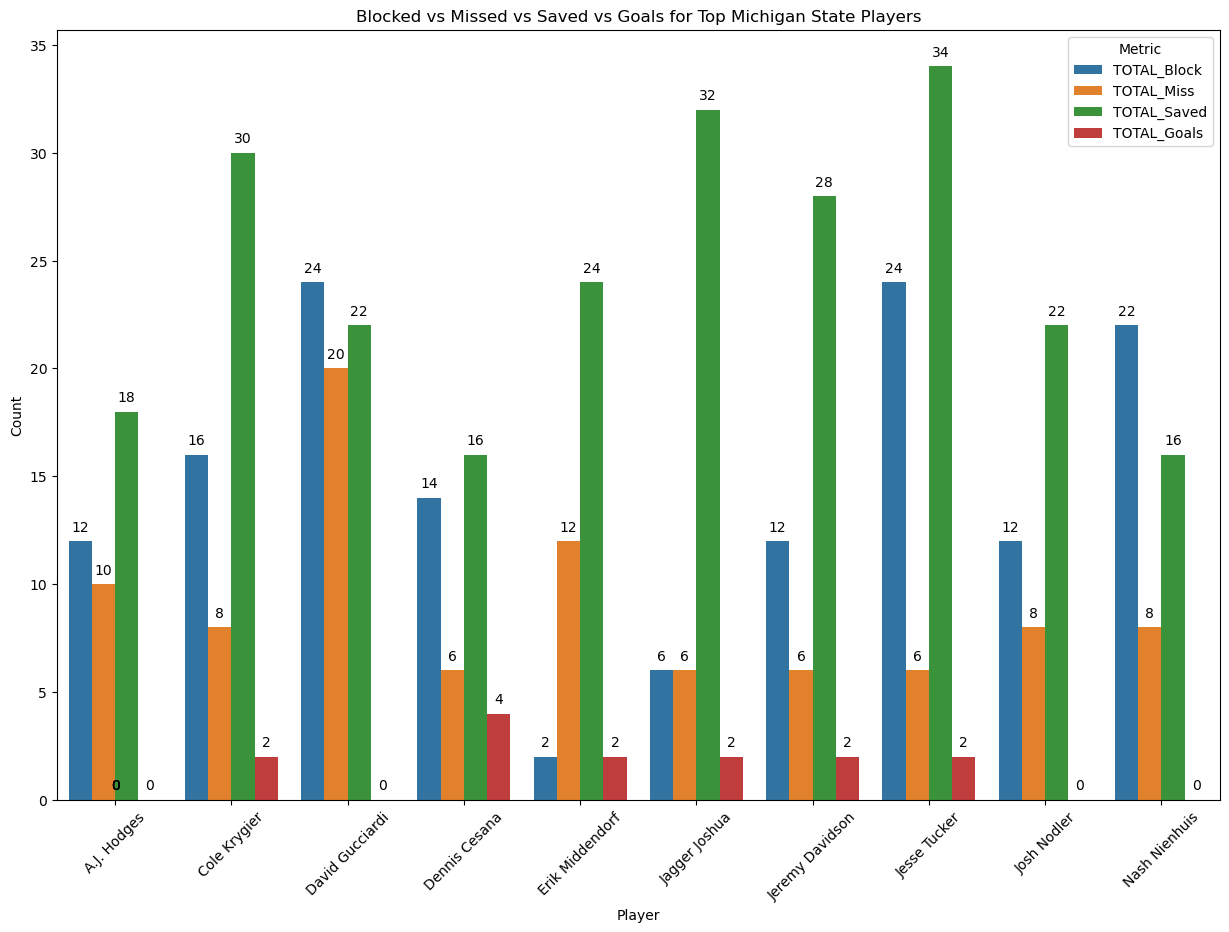

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for visualization
viz_data = advanced_summary_stats['Total Stats'].copy()
viz_data = viz_data.melt(id_vars=['Player'], value_vars=['TOTAL_Block', 'TOTAL_Miss', 'TOTAL_Saved', 'TOTAL_Goals'], 
                         var_name='Metric', value_name='Count')

# Remove the 'TOTAL' row that summarizes the metrics, as it skews the graph
viz_data_filtered = viz_data[viz_data['Player'] != 'TOTAL']

# Calculate the sum of all metrics for each player to identify the top and bottom performers
total_counts = viz_data_filtered.groupby('Player')['Count'].sum().reset_index()
top_performers = total_counts.nlargest(10, 'Count')['Player'].tolist()

# Filter the data to only include the top performers
viz_data_top_performers = viz_data_filtered[viz_data_filtered['Player'].isin(top_performers)]

# Create the visualization
plt.figure(figsize=(15, 10))
sns.barplot(data=viz_data_top_performers, x='Player', y='Count', hue='Metric')

# Add data labels
for p in plt.gca().patches:
    if p.get_height() > -1:  # Only label the bars with height greater than 0
        plt.gca().annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Blocked vs Missed vs Saved vs Goals for Top Michigan State Players')
plt.xticks(rotation=45)
plt.show()
